# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from textblob import TextBlob
import gensim
from gensim import corpora


import nltk
from gensim.models import LdaModel
import spacy

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | Horrible service from boar...
1,Not Verified | My wife and I are very disappo...
2,Not Verified | We flew BA between Heathrow an...
3,Not Verified | Absolutely disgusted with BA. ...
4,Not Verified | Took a trip to Nashville with m...


In [4]:
# Create DataFrame from reviews
df = pd.DataFrame(reviews, columns=["reviews"])

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [5]:
# Clean the reviews by:
# 1. Removing "✅ Trip Verified" and "Not Verified"
# 2. Removing leading '|' and spaces
# 3. Removing extra whitespace
# 4. Handling HTML entities if present
df["reviews"] = df["reviews"].str.replace("✅ Trip Verified", "", regex=False)
df["reviews"] = df["reviews"].str.replace("Not Verified", "", regex=False)
df["reviews"] = df["reviews"].str.replace(r"^\|\s*", "", regex=True)  # Remove leading '|' and spaces
df["reviews"] = df["reviews"].str.strip()  # Remove leading and trailing whitespace
df["reviews"] = df["reviews"].str.replace(r"\s+", " ", regex=True)  # Replace multiple spaces with single space
df["reviews"] = df["reviews"].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())  # Handle HTML entities
# Save the cleaned reviews to a CSV file
df.to_csv("BA_reviews_cleaned.csv", index=False)

# Preview the cleaned reviews
df.head()

/var/folders/my/l5vbwt1d7nq5bs1kh2_49csm0000gq/T/ipykernel_2787/1354587992.py:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df["reviews"] = df["reviews"].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())  # Handle HTML entities


,reviews
0,| Horrible service from boarding to landing. I...
1,| My wife and I are very disappointed with fly...
2,| We flew BA between Heathrow and Berlin one w...
3,| Absolutely disgusted with BA. Our flights we...
4,| Took a trip to Nashville with my wife for a ...


In [6]:
# Function to calculate sentiment polarity
def get_sentiment(review):
    return TextBlob(review).sentiment.polarity

# Apply the sentiment function to the reviews
df["sentiment"] = df["reviews"].apply(get_sentiment)

# Analyze sentiment results
print(df["sentiment"].describe())


count    1000.000000
mean        0.057430
std         0.199875
min        -0.766667
25%        -0.056474
50%         0.043377
75%         0.173250
max         0.715000
Name: sentiment, dtype: float64


In [7]:

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Sample DataFrame (ensure you have your cleaned reviews here)
# df = pd.read_csv("BA_reviews_cleaned.csv")  # Uncomment if you're loading from CSV

# Tokenize and preprocess the reviews
def preprocess(text):
    doc = nlp(text.lower())  # Lowercase
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

df['tokens'] = df['reviews'].apply(preprocess)

# Create a dictionary and corpus
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Display the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.040*"flight" + 0.019*"ba" + 0.013*"|" + 0.013*"hour" + 0.010*"service" + 0.010*"customer" + 0.010*"cancel" + 0.009*"tell" + 0.009*"british" + 0.008*"day"
Topic 1: 0.029*"seat" + 0.019*"flight" + 0.018*"ba" + 0.015*"class" + 0.014*"business" + 0.012*"|" + 0.010*"service" + 0.009*"fly" + 0.008*"cabin" + 0.008*"airline"
Topic 2: 0.028*"flight" + 0.017*"ba" + 0.015*"|" + 0.015*"good" + 0.013*"seat" + 0.013*"time" + 0.011*"service" + 0.011*"food" + 0.010*"crew" + 0.008*"check"
Topic 3: 0.009*"crew" + 0.008*"passenger" + 0.007*"business" + 0.006*"class" + 0.006*"|" + 0.006*"say" + 0.006*"ask" + 0.006*"service" + 0.005*"british" + 0.005*"flight"
Topic 4: 0.020*"flight" + 0.012*"cabin" + 0.010*"|" + 0.010*"ba" + 0.010*"seat" + 0.009*"crew" + 0.008*"time" + 0.007*"service" + 0.006*"passenger" + 0.006*"plane"


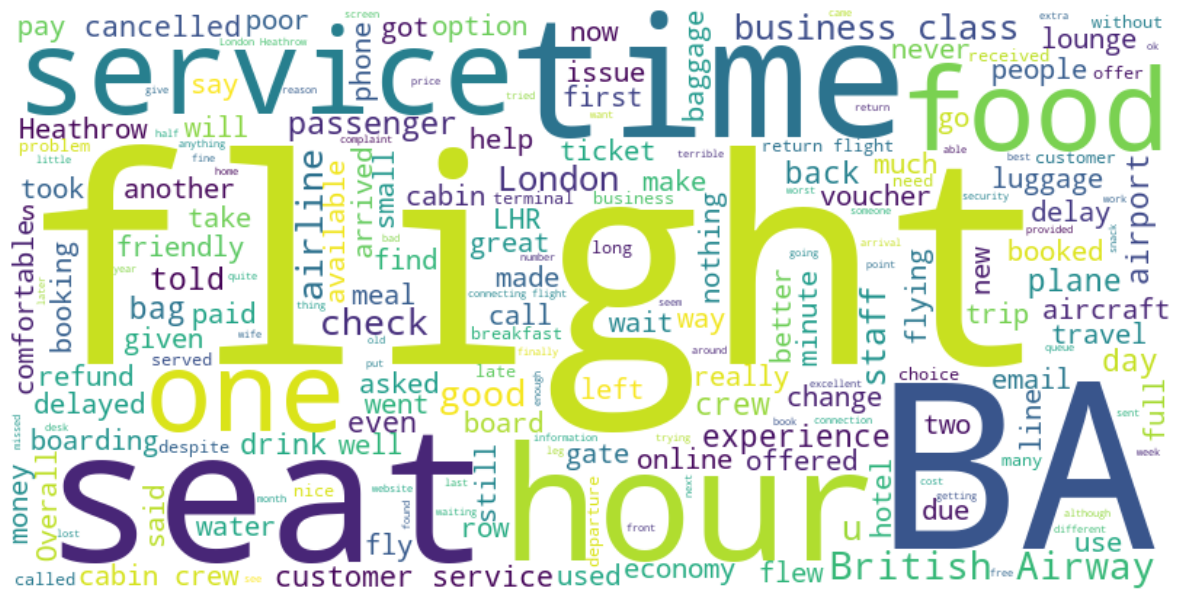

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all reviews into a single string
all_reviews = ' '.join(df['reviews'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [9]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Save to HTML file
pyLDAvis.save_html(vis, 'lda_visualization.html')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=2787) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=2787) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=2787) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=2787) is multi-threaded, use of fork() may lead to deadlocks 

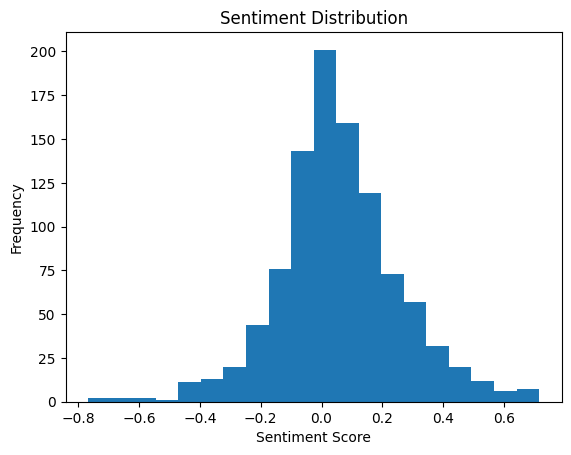

In [10]:
import matplotlib.pyplot as plt

plt.hist(df["sentiment"], bins=20)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()


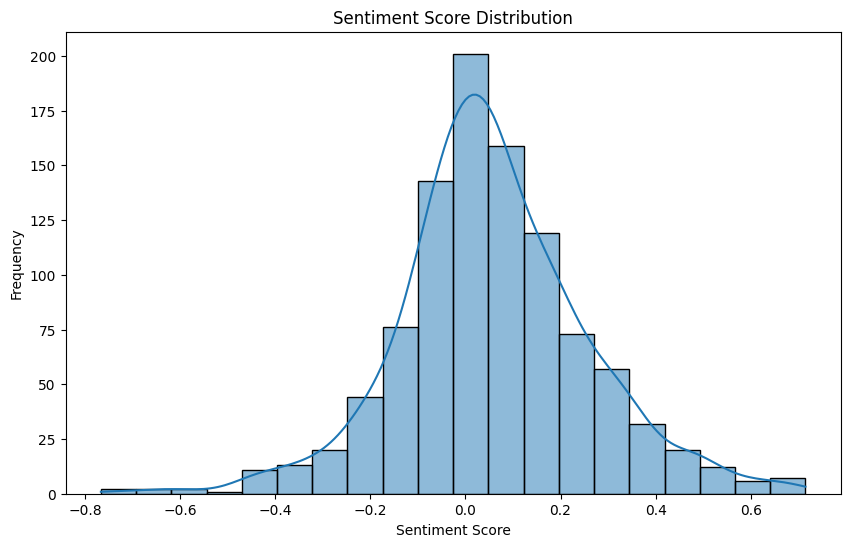

In [11]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=20, kde=True)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


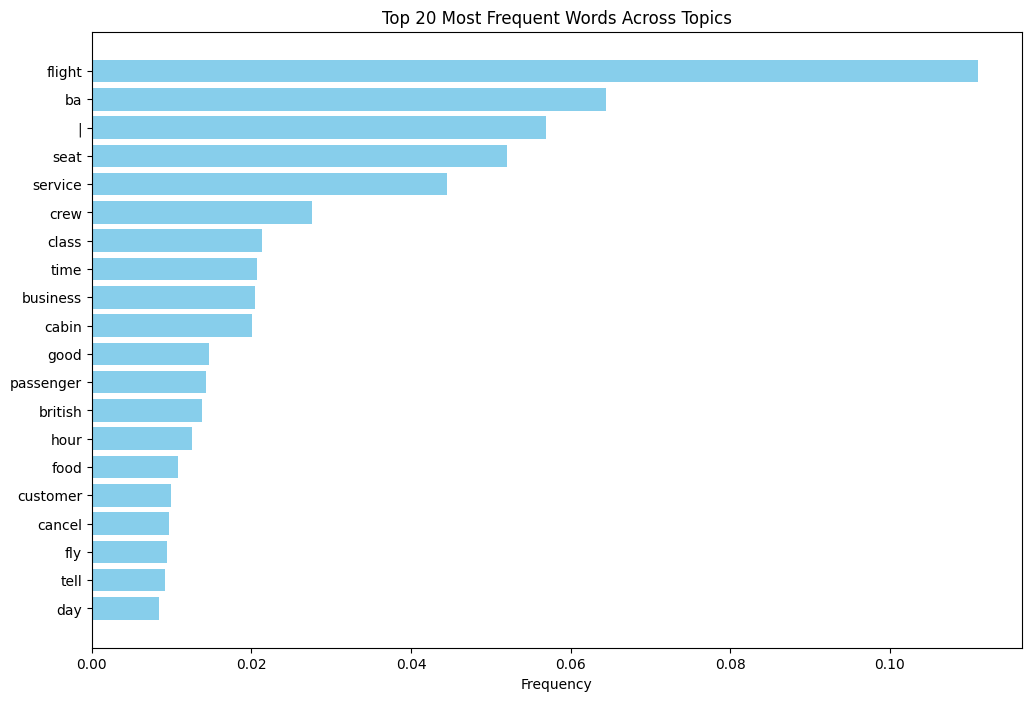

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora

# Extract topics and word distributions
topic_words = lda_model.show_topics(num_words=10, formatted=False)

# Create a DataFrame for easier manipulation
topics_df = pd.DataFrame([(topic_id, word, weight) 
                          for topic_id, words in topic_words 
                          for word, weight in words], 
                         columns=['Topic', 'Word', 'Weight'])

# Sort by topic and weight
sorted_topics_df = topics_df.sort_values(by=['Topic', 'Weight'], ascending=[True, False])

# Frequency Count
word_counts = sorted_topics_df.groupby('Word').sum().reset_index()
word_counts = word_counts.sort_values(by='Weight', ascending=False)

# Plotting Word Frequencies
plt.figure(figsize=(12, 8))
plt.barh(word_counts['Word'].head(20), word_counts['Weight'].head(20), color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Words Across Topics')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()
